FINAL MACHINE LEARNING PIPELINE


This pipeline features:
- open source classes
- in house package class
- only uses selected feature
- we score new data

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

In [30]:
#data manipulation library
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

#for saving the pipeline
import joblib

#packages from scikit learn
from sklearn.ensemble import AdaBoostRegressor as abr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer


#packages from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper


import preprocessors as pp

In [31]:
#loading dataset
df = pd.read_csv('data.csv')

#retrieve number of rows and colums
print(df.shape)

#visualizing sample shot of our data
df.head()

(11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [32]:
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

In [33]:
#remove the spaces and format the case of each column titles
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [34]:
#Let's create our cat vars which will enable us to cast some features to categorical type subsequently
cat_var = [var for var in df.columns if df[var].dtype == 'object']

In [35]:
#remove the spaces and format the case of each column values

for col in cat_var:
    try:
        if df[col].dtype == 'object':
            df[col] = df[col].str.lower().str.replace(' ', '_')
        else:
            df[col] = df[col]
    except TypeError:
        print('wrong data type')

In [36]:
#replace na or nan with 0 in the number_of_doors variable
df['number_of_doors'] = df['number_of_doors'].fillna(0)


#number_of_doors is in actual sense supposed to be a cat var, so we first round the decimal to whole number.
#also we round the values of engine_cylinder to whole number
for i in df.index:
    df['number_of_doors'] = round(df['number_of_doors'][i])
    df['engine_cylinders'] = round(df['engine_cylinders'][i])

#update the data type for number of doors, because in reality it should be a categorical variable and not numerical
df['number_of_doors'] = df['number_of_doors'].astype('object')
df['engine_cylinders'] = df['engine_cylinders'].astype('object')

#add the new categorical variable to the list cat_var
cat_var = cat_var + ['number_of_doors', 'engine_cylinders']

# seperate data into train and test

In [37]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('msrp', axis= 1), #predictive features
                                                    df['msrp'], # target
                                                    test_size=.3,
                                                    random_state= 1,
                                                    )

x_train.shape, x_test.shape

((8339, 15), (3575, 15))

In [38]:
x_train.to_csv('train.csv', index_label=False)
x_test.to_csv('test.csv', index_label=False)

# Target

In [39]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

# Configuration

In [40]:

CATEGORICAL_VARS_WITH_NA_FREQUENT = 'engine_fuel_type'

NUMERICAL_VARS_WITH_NA = 'engine_hp'

TEMPORAL_VAR =  'year'

DROPPED_VARS = 'year'

NUMERICAL_YEO_VARS = ['highway_mpg', 'city_mpg']

CATEGORICAL_VARS = 'engine_fuel_type'

#selected variables
FEATURES =[
    'engine_fuel_type', 
    'engine_hp',   
    'year' # this is important for computing the car age
]

In [41]:
x_train = x_train[FEATURES]
x_test = x_test[FEATURES]

x_train.shape, x_test.shape

((8339, 3), (3575, 3))

In [42]:
x_train.dtypes

engine_fuel_type     object
engine_hp           float64
year                  int64
dtype: object

# PIPELINE

In [43]:
msrp_pipeline = Pipeline([
    # ==== IMPUTATION ====

    ('frequent_imputation', CategoricalImputer(imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),
    
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    ('median_imputation', MeanMedianImputer(imputation_method='median', variables=NUMERICAL_VARS_WITH_NA)),

    # ==== TEMPORAL VARIABLE - CREATING NEW CAR AGE VAR ====
    ('elapsed_time', pp.CarAge(variables=TEMPORAL_VAR)),

    ('drop_features', DropFeatures(features_to_drop=DROPPED_VARS)),

    # === CATEGORIAL ENCODING ====
    ('rare_label_encoder', RareLabelEncoder(tol=0.01, n_categories=1, variables=CATEGORICAL_VARS)),

    #encoding the categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)),

    #scaling our feature parameters
    ('scalar', MinMaxScaler()),

    #final estimator
    ('abr', abr(random_state= 1, n_estimators=100))
])

In [44]:
#train the pipeline
msrp_pipeline.fit(x_train, y_train)

Pipeline(steps=[('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables='engine_fuel_type')),
                ('missing_indicator',
                 AddMissingIndicator(variables='engine_hp')),
                ('median_imputation', MeanMedianImputer(variables='engine_hp')),
                ('elapsed_time', CarAge(variables='year')),
                ('drop_features', DropFeatures(features_to_drop='year')),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables='engine_fuel_type')),
                ('categorical_encoder',
                 OrdinalEncoder(variables='engine_fuel_type')),
                ('scalar', MinMaxScaler()),
                ('abr', AdaBoostRegressor(n_estimators=100, random_state=1))])

In [45]:
# evaluate the model:
# ====================

# make predictions for train set
pred = msrp_pipeline.predict(x_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.expm1(y_train), np.expm1(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.expm1(y_train), np.expm1(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.expm1(y_train), np.expm1(pred))))
print()

# make predictions for test set
pred = msrp_pipeline.predict(x_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.expm1(y_test), np.expm1(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.expm1(y_test), np.expm1(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.expm1(y_test), np.expm1(pred))))
print()

print('Average car price: ', int(np.expm1(y_train).median()))

train mse: 1170387686
train rmse: 34210
train r2: 0.6772432502215824

test mse: 1255953782
test rmse: 35439
test r2: 0.6493202628055048

Average car price:  29904


Text(0.5, 1.0, 'Evaluation of AdaboostRegressor')

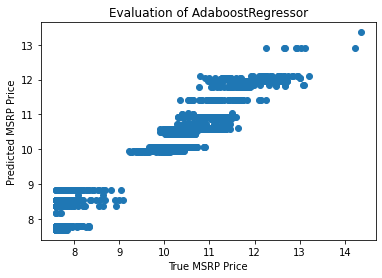

In [46]:
# evaluating our model with respect to the real msrp price
plt.scatter(y_test, msrp_pipeline.predict(x_test))
plt.xlabel('True MSRP Price')
plt.ylabel('Predicted MSRP Price')
plt.title('Evaluation of AdaboostRegressor')

# Score New Data

In [47]:
# load the unseen dataset
data = pd.read_csv('test.csv')
data.head()


,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
4257,lotus,evora_400,2017,premium_unleaded_(required),400.0,6,manual,rear_wheel_drive,2,"exotic,high-performance",compact,coupe,39,21,613
11151,aston_martin,v8_vantage,2014,premium_unleaded_(required),420.0,6,automated_manual,rear_wheel_drive,2,"exotic,high-performance",compact,convertible,21,14,259
5262,hyundai,genesis,2015,regular_unleaded,311.0,6,automatic,rear_wheel_drive,2,"luxury,performance",large,sedan,29,18,1439
8965,suzuki,samurai,1993,regular_unleaded,66.0,6,manual,four_wheel_drive,2,NaN,compact,convertible_suv,26,24,481
7380,mitsubishi,outlander,2015,regular_unleaded,166.0,6,automatic,all_wheel_drive,2,crossover,midsize,4dr_suv,29,24,436


In [48]:
data = data[FEATURES]
print(data.shape)

(3575, 3)


In [49]:
new_vars_with_na = [
    var for var in FEATURES
    if var not in CATEGORICAL_VARS_WITH_NA_FREQUENT + 
    NUMERICAL_VARS_WITH_NA and data[var].isnull().sum() > 0
]

new_vars_with_na

[]

In [50]:
data.head()

,engine_fuel_type,engine_hp,year
4257,premium_unleaded_(required),400.0,2017
11151,premium_unleaded_(required),420.0,2014
5262,regular_unleaded,311.0,2015
8965,regular_unleaded,66.0,1993
7380,regular_unleaded,166.0,2015


In [51]:
y_pred = msrp_pipeline.predict(data)
y_pred = np.expm1(y_pred)
y_pred # predicted values


array([91898.71122988, 91898.71122988, 39750.40938361, ...,
        5172.23995104, 23464.96600871, 40966.23555572])

In [52]:
np.expm1(y_test) #actual values

4257      91900.0
11151    136900.0
5262      38000.0
8965       2000.0
7380      26195.0
           ...   
10000      2000.0
8919       2000.0
239        2847.0
8384      26640.0
5207      31755.0
Name: msrp, Length: 3575, dtype: float64